<a href="https://colab.research.google.com/github/Ambaright/ST-554-Project1/blob/main/Task2/ST554_Project_1_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ST 554 Project 1: Task 2
Programmed by: Amanda Baright

## Introduction

The increasing incidence of respiratory illness and the known carcinogenic risks associated with prolonged exposure to pollutants like benzene (`C6H6(GT)`) have made precise urban air quality monitoring a critical priority for public health and municipal traffic management. Currently, urban monitoring relies on sparse networks of fixed stations equipped with high-precision industrial spectrometers; however, the high cost and significant size of these instruments prevent the deployment of a monitoring mesh dense enough to capture the complex, turbulent diffusion of gases in a city environment. To address this gap, research has shifted toward low-cost gas multi-sensor devices, often termed "electronic noses," which utilize solid-state sensors to provide a more granular view of urban pollution.

The provided report examines data from a 13-month measurement campaign (March 2004 to April 2005) conducted along a high-traffic road in an Italian city. The study’s primary objective was to evaluate the feasibility of using these low-cost devices to "densify" existing monitoring networks by comparing their readings against "Ground Truth" (GT) reference data provided by a conventional monitoring station. The dataset includes hourly mean concentrations for several "true" pollutants - `CO`, `NMHC`, `C6H6`, `NOx`, and `NO2` - recorded alongside the responses of five metal oxide chemoresistive sensors (targeted at CO, NMHC, NOx, NO2, and O3) and two sensors for weather-related variables, specifically temperature (`T`), relative humidity (`RH`), and absolute humidity (`AH`).

A central focus of this analysis is the estimation of `C6H6(GT)` (benzene). Notably, the multi-sensor device used in the study did not include a sensor specifically targeted at benzene. Instead, the study aimed to reconstruct benzene levels by employing artificial neural networks to exploit the significant linear correlations that exist between different urban pollutants. For instance, a very strong correlation coefficient of 0.98 was observed between `benzene` and Non-Metanic Hydrocarbons (`NMHC`).

Furthermore, the study investigates the critical role of atmospheric dynamics, as the stability and selectivity of solid-state sensors are heavily influenced by seasonal changes and weather variables. Earlier findings suggest that sensor performance can be impacted by rapid shifts in humidity and low temperatures, which may necessitate periodic re-calibration to account for sensor drift and changing gas mixture ratios in the winter. By conducting an Exploratory Data Analysis (EDA) on the relationships between sensor outputs, weather conditions, and benzene concentrations, this report seeks to understand the effectiveness of "cooperative" sensor fusion in providing reliable, low-cost environmental monitoring.

## Reading in the Data

In this section, the data is read in from [Air Quality Data](https://archive.ics.uci.edu/dataset/360/air+quality) and the features are extracted and stored into a saved DataFrame `air`. We then investigate the data to understand how it is stored using `.head()` and `.info()` methods. With `.head()` we can see what the first five rows of our data look like, and with `.tail()` we can see what the last five rows of our data look like. With `.info()` we can see the data types for each variable.

In [1]:
# Install ucimlrepo if you haven't already
!pip install ucimlrepo

# Import needed packages
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch dataset
air_quality = fetch_ucirepo(id=360)

# Extract the Features
air = air_quality.data.features
print(".head()")
print(air.head())
print("\n" + ".tail()")
print(air.tail())


.head()
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7

In [2]:
# Summary of DataFrame
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


## Do Basic Data Validation

When examining data, it is best practice to look at quick summary statistics of all the data to check that things make sense. We can do this using the `.describe()` method on the DataFrame. This will produce the count, mean, standard deviation, min, 25th quantile, median, 75th quantile, and the max.

It should be noted that from the variable information provided, missing values are tagged with `-200` value. This then explains the common min of -200. Once we determine the rate of missingness and convert these missing values to `NaN`, we can then rerun this for a second data validation.

Additionally, the max values for each variable seem quite high compared to the 75th quantile, which indicates a potential outlier. However, there are no alarming values that would indicate a data entry error.

In [3]:
air.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


## Determine rate of missing values

Now that we looked at how the data was stored, we want to determine the rate of missing values. It's important to note again that the dataset uses the value `-200` to indicate a missing value. Thus, we will need to look for any cases of `-200` and switch it to `NaN`. Here we'll use the `.replace()` method to do this task.

In [4]:
air.replace(-200, np.nan, inplace = True)

Now we can look at the summary statistics for the data to see if our min values changed.

In [5]:
air.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


Now we see that all of our min values are unique to each variable. This will allow us to easily see the unique distribtuion for each variable and the relationships between the different variables.

Additionally, we can now determine the rate of missing values by summing up (with the `.sum()` method) the number of instances where the `.isnull()` method returns `True`. This `.isnull()` method will return true if a value is `NaN`.

In [6]:
air.isnull().sum()

,0
Date,0
Time,0
CO(GT),1683
PT08.S1(CO),366
NMHC(GT),8443
C6H6(GT),366
PT08.S2(NMHC),366
NOx(GT),1639
PT08.S3(NOx),366
NO2(GT),1642


The table above lists the rate of missingness for each variable in our DataFrame. From this table, we see that `NMHC(GT)` had the highest rate of missingness with n = 8443 missing values, followed by `CO(GT)` (n = 1683), `NO2(GT)` (n = 1642), and `NOx(GT)` (n = 1639). The other variables of interest (excluding `Time` and `Date`) have n = 366 missing values.

## Data Cleaning

Now that we replaced our missing values with `NaN` and re-calculated the summary statistics with `.describe()` for our basic data validation, we can now move onto some data cleaning. For the purposes of EDA, we'll remove all rows with missing values (`NaN`) using `.dropna()`.

In [7]:
air.dropna(inplace = True)

# Verify all NaN are dropped
air.isnull().sum()

,0
Date,0
Time,0
CO(GT),0
PT08.S1(CO),0
NMHC(GT),0
C6H6(GT),0
PT08.S2(NMHC),0
NOx(GT),0
PT08.S3(NOx),0
NO2(GT),0


Now that we dropped all rows with missing values, we can rename some of these columns to be easier to work with using the `.rename()` method from `pandas`. We can do this by creating a dictionary, where the old names are the keys and the new names are the values. We then use the `.rename()` method with the columns set to be the new names.

In [8]:
new_air_names = {
    'C6H6(GT)': 'benzene',
    'CO(GT)': 'CO',
    'NOx(GT)': 'NOx',
    'NO2(GT)': 'NO2',
    'NMHC(GT)': 'NMHC',
    'PT08.S1(CO)': 'sensorCO',
    'PT08.S2(NMHC)': 'sensorNMHC',
    'PT08.S3(NOx)': 'sensorNOx',
    'PT08.S4(NO2)': 'sensorNO2',
    'PT08.S5(O3)': 'sensorO3',
    'T': 'Temp',
    'RH': 'relHumidity',
    'AH': 'absHumidity'
}

air.rename(columns = new_air_names, inplace = True)

# Check that the variables have the new names
air.head()

,Date,Time,CO,sensorCO,NMHC,benzene,sensorNMHC,NOx,sensorNOx,NO2,sensorNO2,sensorO3,Temp,relHumidity,absHumidity
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


For the remaining data exploration, we will focus on the relationship between `benzene` and the sensor variables, `Temp`, `relHumidity`, `absHumidity`, `Date`, and `Time`. Thus, we may want a subsetted DataFrame with just these variables, which is done by copying our `air` DataFrame with `.copy()` and using the `.drop()` method.

In [9]:
sub_air = air.copy()

sub_air = sub_air.drop(columns = ["CO", "NMHC", "NOx", "NO2"])
sub_air.head()

,Date,Time,sensorCO,benzene,sensorNMHC,sensorNOx,sensorNO2,sensorO3,Temp,relHumidity,absHumidity
0,3/10/2004,18:00:00,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,3/10/2004,19:00:00,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,3/10/2004,20:00:00,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,3/10/2004,21:00:00,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888


### Creating New Variables

Now that we have a subset of our `air` data, we may want to create new variables that can be used in our exploratory data analysis. This section will cover the creation of the following variables:

* High vs Low Value Variables: Looking at the median of the variable, and determining if the current observation has a higher or lower value.

* Month, Day, and Year Categorical Variables: Categorical variables of the month name, day of the week, and numeric and categorical variables for the year.

* Season: Using a defined user-function to determine which season the observation falls in.

* Time of Day: A categorical variable for the time of day the observation was recorded.

#### High vs Low Value Variables

Now that we have a subset of our `air` data, we may want to create new variables for our exploratory data analysis.

The first set of variables we may want to consider is a categorical variable for each sensor value, `Temp`, `relHumidity`, and `absHumidity`, where the variable takes on a value of `high` if the observation has a value higher than the median and a value of `low` if the observation has a value lower than the median. Here we will use the median as its less susceptible to the influence of outliers. To make this process easier, we'll use a `for` loop to do this for each variable of interest.

In [10]:
# List of variables
variables = ["benzene","sensorCO", "sensorNMHC", "sensorNOx", "sensorNO2", "sensorO3", "Temp", "relHumidity", "absHumidity"]

# Using a for loop to create a categorical variable for each variable in the list variables
for var in variables:
    # Calculate the median of the current variable
    median = sub_air[var].median()

    # Create a new categorical column
    new_level_col = f"{var}_level"

    # Using np.where() to assign the value high and low, where its high if value > median
    # Add this new_level_col to the exisiting sub_air DataFrame
    sub_air[new_level_col] = np.where(sub_air[var] > median, 'high', 'low')

    # Make the new variable a category variable
    sub_air[new_level_col] = sub_air[new_level_col].astype('category')

# Check the .head() of sub_air with these new variables
sub_air.head()


,Date,Time,sensorCO,benzene,sensorNMHC,sensorNOx,sensorNO2,sensorO3,Temp,relHumidity,absHumidity,benzene_level,sensorCO_level,sensorNMHC_level,sensorNOx_level,sensorNO2_level,sensorO3_level,Temp_level,relHumidity_level,absHumidity_level
0,3/10/2004,18:00:00,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578,high,high,high,high,high,high,low,low,low
1,3/10/2004,19:00:00,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255,high,high,high,high,high,low,low,low,low
2,3/10/2004,20:00:00,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502,low,high,low,high,low,high,low,high,low
3,3/10/2004,21:00:00,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867,high,high,high,high,high,high,low,high,low
4,3/10/2004,22:00:00,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888,low,high,low,high,low,high,low,high,low


We might want to reorder some of these variables so that the categorical variable is next to the numeric variable.

In [11]:
var_order = ["Date", "Time", "benzene", "benzene_level", "sensorCO", "sensorCO_level", "sensorNMHC", "sensorNMHC_level",
                "sensorNOx", "sensorNOx_level", "sensorNO2", "sensorNO2_level", "sensorO3", "sensorO3_level",
                "Temp", "Temp_level", "relHumidity", "relHumidity_level", "absHumidity", "absHumidity_level"]

sub_air = sub_air[var_order]
sub_air.head()

,Date,Time,benzene,benzene_level,sensorCO,sensorCO_level,sensorNMHC,sensorNMHC_level,sensorNOx,sensorNOx_level,sensorNO2,sensorNO2_level,sensorO3,sensorO3_level,Temp,Temp_level,relHumidity,relHumidity_level,absHumidity,absHumidity_level
0,3/10/2004,18:00:00,11.9,high,1360.0,high,1046.0,high,1056.0,high,1692.0,high,1268.0,high,13.6,low,48.9,low,0.7578,low
1,3/10/2004,19:00:00,9.4,high,1292.0,high,955.0,high,1174.0,high,1559.0,high,972.0,low,13.3,low,47.7,low,0.7255,low
2,3/10/2004,20:00:00,9.0,low,1402.0,high,939.0,low,1140.0,high,1555.0,low,1074.0,high,11.9,low,54.0,high,0.7502,low
3,3/10/2004,21:00:00,9.2,high,1376.0,high,948.0,high,1092.0,high,1584.0,high,1203.0,high,11.0,low,60.0,high,0.7867,low
4,3/10/2004,22:00:00,6.5,low,1272.0,high,836.0,low,1205.0,high,1490.0,low,1110.0,high,11.2,low,59.6,high,0.7888,low


#### Month, Day, and Year Categorical Variables

For the next new variable, we may want to explore the `Date` column and see if we notice any trends across the month, day of the week, and year. For this we can create a new variable for each of these components. However, before we start this process, we will need to convert `Date` to be a workable datetime object. Once we do this, we can use the datatime accessor `.dt` to extract the information we need. We will also convert this information into ordered categories.

In [12]:
# Make `Date` a datetime object
sub_air['Date'] = pd.to_datetime(sub_air['Date'], errors = "coerce")

# Extract the month name & convert to ordered category
sub_air['month'] = sub_air['Date'].dt.month_name()
sub_air['month'] = pd.Categorical(sub_air['month'],
                                 categories = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
                                 ordered = True)

# Extract day of the week & convert to ordered category
sub_air['day'] = sub_air['Date'].dt.day_name()
sub_air['day'] = pd.Categorical(sub_air['day'],
                               categories = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday'],
                               ordered = True)

# Extract the year, except here we will have a numeric and category type variable
sub_air['year'] = sub_air['Date'].dt.year
sub_air['year_cat'] = sub_air['year'].astype('category')

# Check the .head() of sub_air with these new variables
sub_air.head()


,Date,Time,benzene,benzene_level,sensorCO,sensorCO_level,sensorNMHC,sensorNMHC_level,sensorNOx,sensorNOx_level,...,Temp,Temp_level,relHumidity,relHumidity_level,absHumidity,absHumidity_level,month,day,year,year_cat
0,2004-03-10,18:00:00,11.9,high,1360.0,high,1046.0,high,1056.0,high,...,13.6,low,48.9,low,0.7578,low,March,Wednesday,2004,2004
1,2004-03-10,19:00:00,9.4,high,1292.0,high,955.0,high,1174.0,high,...,13.3,low,47.7,low,0.7255,low,March,Wednesday,2004,2004
2,2004-03-10,20:00:00,9.0,low,1402.0,high,939.0,low,1140.0,high,...,11.9,low,54.0,high,0.7502,low,March,Wednesday,2004,2004
3,2004-03-10,21:00:00,9.2,high,1376.0,high,948.0,high,1092.0,high,...,11.0,low,60.0,high,0.7867,low,March,Wednesday,2004,2004
4,2004-03-10,22:00:00,6.5,low,1272.0,high,836.0,low,1205.0,high,...,11.2,low,59.6,high,0.7888,low,March,Wednesday,2004,2004


#### Season Variable

Another thing we may want to consider is the season (Winter, Spring, Summer, Fall). We'll then use common days throughout the year to determine when the seasons change. That is:

* Winter: New Years up to March 21st and Dec 21 to New Years Eve
* Spring: up to June 20
* Summer: up to Sept 22
* Fall: up to Dec 21

Here we can define a function called `seasons` to determine which season a date may fall in using the date ranges defined above. We then use a lambda function to apply this `seasons` function to each date. Finally, we want to ensure that the order of these seasons remain true when we begin to perform our EDA. For this, we convert the `season` variable into an ordered categorical.

In [13]:
# Create a seasons variable
def seasons(date: datetime):

    '''
    Taking in a date, that is a datetime object, we will pull out the month and day to determine which season the date falls in.

    Winter is defined as New Years up to March 21st and Dec 21 to New Years Eve
    Spring is defined as March 21 up to June 20
    Summer is defined as June 21 up to Sept 22
    Fall is defined as Sept 23 up to Dec 21

    We then return the season as a category.
    '''

    m = date.month
    d = date.day

    if (m == 12 and d >= 21) or m in [1, 2] or (m == 3 and d < 21):
        return 'Winter'
    elif (m == 3 and d >= 21) or m in [4, 5] or (m == 6 and d < 21):
        return 'Spring'
    elif (m == 6 and d >= 21) or m in [7, 8] or (m == 9 and d < 23):
        return 'Summer'
    elif (m == 9 and d >= 23) or m in [10, 11] or (m == 12 and d < 21):
        return 'Fall'

    return season

# Use a lambda function to apply the seasons function
sub_air['season'] = sub_air.apply(lambda x: seasons(x['Date']), axis=1)

# Convert the season to a ordered category
sub_air['season'] = pd.Categorical(sub_air['season'], categories=['Winter', 'Spring', 'Summer', 'Fall'], ordered=True)

# Check sub_air with .head() again
sub_air.head()

,Date,Time,benzene,benzene_level,sensorCO,sensorCO_level,sensorNMHC,sensorNMHC_level,sensorNOx,sensorNOx_level,...,Temp_level,relHumidity,relHumidity_level,absHumidity,absHumidity_level,month,day,year,year_cat,season
0,2004-03-10,18:00:00,11.9,high,1360.0,high,1046.0,high,1056.0,high,...,low,48.9,low,0.7578,low,March,Wednesday,2004,2004,Winter
1,2004-03-10,19:00:00,9.4,high,1292.0,high,955.0,high,1174.0,high,...,low,47.7,low,0.7255,low,March,Wednesday,2004,2004,Winter
2,2004-03-10,20:00:00,9.0,low,1402.0,high,939.0,low,1140.0,high,...,low,54.0,high,0.7502,low,March,Wednesday,2004,2004,Winter
3,2004-03-10,21:00:00,9.2,high,1376.0,high,948.0,high,1092.0,high,...,low,60.0,high,0.7867,low,March,Wednesday,2004,2004,Winter
4,2004-03-10,22:00:00,6.5,low,1272.0,high,836.0,low,1205.0,high,...,low,59.6,high,0.7888,low,March,Wednesday,2004,2004,Winter


#### Time of Day Variable

Now we might want to create a time of day variable to see if our levels of `benzene` change throughout the day. We can define the time blocks as:

* Midnight (00:00–04:59)
* Dawn (05:00–06:59)
* Morning (07:00–11:59)
* Afternoon (12:00–16:59)
* Evening (17:00–19:59)
* Dusk (20:00–23:59)

To do this, we will create a user defined function that will take in our current time observation and convert it into a datetime. We will then examine the hour of the time to sort it into the time categories that are defined above. We will then apply this new function to a new variable called `timeOfDay` in the DataFrame. Finally, we will convert this variable into an ordered categorical variable to preserve the provided order.

In [14]:
# Start with the user defined function
def timeOfDayFunction(time_string: str):

    '''
    Taking in a time, that is a string, we will convert it into a datetime variable.
    We will then extract the hour to be used in our conditional logic.

    Our time ranges are defined as:
    * Midnight (00:00–04:59)
    * Dawn (05:00–06:59)
    * Morning (07:00–11:59)
    * Afternoon (12:00–16:59)
    * Evening (17:00–19:59)
    * Dusk (20:00–23:59)

    We will return the category as a string for the corresponding hour range the time falls in.
    '''

    t = pd.to_datetime(time_string).time()
    hour = t.hour

    if 0 <= hour < 5:
        return 'Midnight'
    elif 5 <= hour < 7:
        return 'Dawn'
    elif 7 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 20:
        return 'Evening'
    else:
        return 'Dusk'

# Now apply this user defined function to the new variable in the DataFrame
sub_air['timeOfDay'] = sub_air['Time'].apply(timeOfDayFunction)

# Now convert to an ordered categorical variable
sub_air['timeOfDay'] = pd.Categorical(sub_air['timeOfDay'], categories=['Midnight', 'Dawn', 'Morning', 'Afternoon', 'Evening', 'Dusk'], ordered=True)

# Check sub_air with .head()
sub_air.head()


,Date,Time,benzene,benzene_level,sensorCO,sensorCO_level,sensorNMHC,sensorNMHC_level,sensorNOx,sensorNOx_level,...,relHumidity,relHumidity_level,absHumidity,absHumidity_level,month,day,year,year_cat,season,timeOfDay
0,2004-03-10,18:00:00,11.9,high,1360.0,high,1046.0,high,1056.0,high,...,48.9,low,0.7578,low,March,Wednesday,2004,2004,Winter,Evening
1,2004-03-10,19:00:00,9.4,high,1292.0,high,955.0,high,1174.0,high,...,47.7,low,0.7255,low,March,Wednesday,2004,2004,Winter,Evening
2,2004-03-10,20:00:00,9.0,low,1402.0,high,939.0,low,1140.0,high,...,54.0,high,0.7502,low,March,Wednesday,2004,2004,Winter,Dusk
3,2004-03-10,21:00:00,9.2,high,1376.0,high,948.0,high,1092.0,high,...,60.0,high,0.7867,low,March,Wednesday,2004,2004,Winter,Dusk
4,2004-03-10,22:00:00,6.5,low,1272.0,high,836.0,low,1205.0,high,...,59.6,high,0.7888,low,March,Wednesday,2004,2004,Winter,Dusk


Now that we created a few more variables that we can use in our exploratory data analysis we can move forward with investigating the relationship between all of these variables and `benzene`.

## Numerical Summaries

In this section, we'll examine the numeric summary of `benzene` on its own and then at different levels/ combinations of other variables. It's when we examine the numeric summaries of benzene with other variables that we'll use our newly created categorical variables.

However, first we want to understand the baseline numeric summary of `benzene`, which can be done using just the `.describe()` method. From these results we see that on average `benzene` levels are 10.77, with a standard deviation of 7.42. The median `benzene` level is 9.10, with a min of 0.50 and a max of 39.20. Due to the relatively large standard deviation and spread between the min and max, we could assume that `benzene` is not symmetric, making the median a better measure of center, which motivated using the median as the separating point for the high and low category creation.


In [15]:
sub_air['benzene'].describe().round(decimals = 2)

,benzene
count,827.00
mean,10.77
std,7.42
min,0.50
25%,4.80
50%,9.10
75%,14.80
max,39.20


Now, we may want to see how these numeric summaries change across different categorical levels of the sensor variables and temperature variables. Here, we will use `.groupby()` to calculate the numeric summaries across the high and low categories for some of the sensor variables and the temperature variables.

For the sensor variables, we may be particularly interested in the relationship between `benzene` and `NMHC`, `CO`, and `NOx` as the literature suggests that these pollutants are highly correlated with `benzene`.

When we exmaine `benzene` numeric summaries across the high and low levels of `NMHC`, we see that the `high` level of `NMHC` has much higher summary statistics for `benzene` than at the `low` level of `NMHC`. In particular, for the `high` group of `NMHC`, we have a mean of 16.58, a standard deviation of 6.09, and a median of 14.8. Whereas, for the `low` group of `NMHC`, we have a mean of 4.98, a standard deviation of 2.40, and a median of 4.8. This suggests a possible linear relationship between `benzene` and `sensorNMHC`, which can be confirmed in our correlation section.


In [16]:
# Start with numeric summary for benzene across sensorNMHC_level
sub_air.groupby('sensorNMHC_level', observed = False)['benzene'].describe().round(decimals = 2)

,count,mean,std,min,25%,50%,75%,max
sensorNMHC_level,,,,,,,,
high,413.0,16.58,6.09,9.2,11.9,14.8,19.90,39.2
low,414.0,4.98,2.40,0.5,3.0,4.8,7.07,9.1


We then move onto examining the `benzene` summary statistics across the high and low levels of `sensorCO`. We see another similar trend, where the `high` category has much higher summary statistics than the `low` category, again suggesting a possible linear relationship between `benzene` and `sensorCO`. We specifically note that for `high` levels of `sensorCO`, `benzene` has a mean of 16.17, a standard deviation of 6.53, and a median of 14.80, and for `low` levels of `sensorCO`, `benzene` has a mean of 5.38, a standard deviation of 3.02, and a median of 4.85.

In [17]:
# numeric summary for benzene across sensorCO_level
sub_air.groupby('sensorCO_level', observed = False)['benzene'].describe().round(decimals = 2)

,count,mean,std,min,25%,50%,75%,max
sensorCO_level,,,,,,,,
high,413.0,16.17,6.53,3.6,11.5,14.80,19.9,39.2
low,414.0,5.38,3.02,0.5,3.0,4.85,7.5,14.4


Next, we can look at examining the `benzene` summary statistics across the high and low categories of `sensorNOx`. Unlike the previous two sensor variables, we see that `benzene` has higher summary statistics for the `low` level compared to the `high` level. That is, at the `low` level, `benzene` has a mean of 16.25, a standard deviation of 6.42, and a median of 14.8. Whereas, as the `high` level, `benzene` has a mean of 5.28, a standard deviation of 2.94, and a median of 4.8. This again implies a possible linear relationship between `sensorNOx` and `benzene`.

In [18]:
# numeric summary for benzene across sensorNOx_level
sub_air.groupby('sensorNOx_level', observed = False)['benzene'].describe().round(decimals = 2)

,count,mean,std,min,25%,50%,75%,max
sensorNOx_level,,,,,,,,
high,413.0,5.28,2.94,0.5,3.00,4.8,7.3,15.2
low,414.0,16.25,6.42,5.9,11.32,14.8,19.9,39.2


Now moving away from the sesnor variables, we may want to examine if `benzene` levels change with different levels of temperature. From the numeric summaries, we see that `high` levels of temperature have a higher mean (13.3) and a higher median (6.25); however, the standard deviation between the `high` and `low` levels are similar with the `high` level having a standard deviation of 7.16 and the `low` level a standard deviation of 6.80. Then for the `low` level, the `benzene` pollutant had a mean of 8.27 and a median of 6.25.

In [19]:
# numeric summaries of benzene across temp_level
sub_air.groupby('Temp_level', observed = False)['benzene'].describe().round(decimals = 2)

,count,mean,std,min,25%,50%,75%,max
Temp_level,,,,,,,,
high,411.0,13.30,7.16,0.7,8.0,12.40,17.6,39.2
low,416.0,8.27,6.80,0.5,3.3,6.25,11.2,36.7


We then might want to look at how `benzene` levels change across the `high` and `low` category of `relHumidity`. We see that for both levels of `relHumidity` there are similar standard deviations with `low` levels having a standard deviation of 7.26 and the `high` levels having a standard deviation of 7.39. However, we see that the `low` level of `relHumidity` has a higher mean (11.95) and median (11.0) compared to the `high` level that has a mean of 9.59 and a median 0f 7.40.

In [20]:
# numeric summaries of benzene across relHumidity_level
sub_air.groupby('relHumidity_level', observed = False)['benzene'].describe().round(decimals = 2)

,count,mean,std,min,25%,50%,75%,max
relHumidity_level,,,,,,,,
high,412.0,9.59,7.39,0.6,3.90,7.4,13.7,36.7
low,415.0,11.95,7.26,0.5,6.45,11.0,15.8,39.2


One thing we may want to examine is how levels of `benzene` changes across both temperature and relative humidity categories. The literature suggests that the peaks in estimation error are associated with low temperatures following rapid decreases in humidity. Thus, we can investigate the numeric summaries with grouping on both groups.

In [21]:
# numeric summaries for benzene across Temp_level and relHumidity_level
sub_air.groupby(['Temp_level', 'relHumidity_level'], observed = False)['benzene'].describe().round(decimals = 2)

count   mean   std  min   25%    50%    75%  \
Temp_level relHumidity_level                                                
high       high                79.0  13.85  7.50  0.8  8.60  13.70  17.10   
           low                332.0  13.17  7.08  0.7  8.00  12.15  17.73   
low        high               333.0   8.58  7.01  0.6  3.60   6.40  11.20   
           low                 83.0   7.06  5.79  0.5  2.45   5.30  11.05   

                               max  
Temp_level relHumidity_level        
high       high               36.2  
           low                39.2  
low        high               36.7  
           low                24.6

As mentioned, the literature suggests some estimation error is associated with low temps and low levels of relative humidity. In our numeric summaries, within the low temp and low relHumidity group, we see the lowest values with a mean of 7.06, standard deviation of 5.79, and a median of 5.30. This lower standard deviation may lead us to investigate more into this claim on estimation error within low temps and low levels of relative humidity, as the smaller standard deviation implies less variation in the `benzene` levels.

## Correlations

Now we can investigate a correlation matrix between all numeric variables (our numeric sensor variables and weather variables). This will give us a good idea on which variables are linearly related.

One thing we want to keep in mind with our correlation investigation, is noting how close our calcualted correlations are with the literature correlations. From Table 2 in the literature, we know that `benzene (C6H6)` has a strong correlation with `NMHC` (r = 0.98) and with `CO` (r = 0.90). The literature also suggests a srong correlation between `CO` and `NOx` (r = 0.78) and `NOx` and `NO2` (r = 0.76).

In [22]:
# correlation between numeric variables
sub_air[["benzene", "sensorNMHC","sensorCO","sensorNOx", "sensorNO2","sensorO3", "Temp", "relHumidity", "absHumidity"]].corr().round(decimals = 2)


,benzene,sensorNMHC,sensorCO,sensorNOx,sensorNO2,sensorO3,Temp,relHumidity,absHumidity
benzene,1.00,0.98,0.93,-0.85,0.96,0.90,0.42,-0.18,0.31
sensorNMHC,0.98,1.00,0.94,-0.91,0.96,0.91,0.45,-0.19,0.33
sensorCO,0.93,0.94,1.00,-0.83,0.95,0.94,0.32,-0.04,0.41
sensorNOx,-0.85,-0.91,-0.83,1.00,-0.88,-0.86,-0.42,0.10,-0.46
sensorNO2,0.96,0.96,0.95,-0.88,1.00,0.92,0.34,0.01,0.52
sensorO3,0.90,0.91,0.94,-0.86,0.92,1.00,0.31,-0.01,0.44
Temp,0.42,0.45,0.32,-0.42,0.34,0.31,1.00,-0.77,0.16
relHumidity,-0.18,-0.19,-0.04,0.10,0.01,-0.01,-0.77,1.00,0.48
absHumidity,0.31,0.33,0.41,-0.46,0.52,0.44,0.16,0.48,1.00


From the correlation matrix we see, that some of the trends observed in the literature remain true with the sensor variables. More specifically, `benzene` and `sensorNMHC` have a strong positive linear relationship with a correlation of 0.98 and `benzene` and `sensorCO` have a strong positive linear relationship with a correlation of 0.93. We also see that `sensorCO` and `sensorNOx` have a strong negative linear relationship with a correlation of -0.83 and that `sensorNOx` and `sensorNO2` also have a strong negative linear relationship with a correlation of -0.88.

We also observe that almost all of the sensor variables are strongly correlated with each other, with some having strong positive linear relationships and others having strong negative linear relationships. When examining the linear relationships between the weather variables and the sensor variables, we don't see any strong linear relationship. However, we do see that `Temp` and `relHumidity` have a moderate negative linear relationship with a correlation of -0.77, which makes sense given that the literature notes that the sensor readings do change relative to temperature and relative humidity. More specifically, the sources note that peaks in estimation error are often associated with low temperatures following rapid decreases in humidity.

### Ground Truth and Sensor Correlations

Another thing we may want to consider is the linear relationship between the Ground Truth readings and the sensor readings. Going back to our original `air` data, we can look at the correlation matrix.

In [23]:
# correlations of ground truth and sensor variables
air[["CO", "sensorCO", "NOx", "sensorNOx", "NO2", "sensorNO2", "NMHC", "sensorNMHC"]].corr().round(decimals = 2)

,CO,sensorCO,NOx,sensorNOx,NO2,sensorNO2,NMHC,sensorNMHC
CO,1.00,0.94,0.95,-0.82,0.86,0.94,0.89,0.96
sensorCO,0.94,1.00,0.92,-0.83,0.87,0.95,0.78,0.94
NOx,0.95,0.92,1.00,-0.81,0.86,0.91,0.81,0.93
sensorNOx,-0.82,-0.83,-0.81,1.00,-0.82,-0.88,-0.77,-0.91
NO2,0.86,0.87,0.86,-0.82,1.00,0.81,0.73,0.89
sensorNO2,0.94,0.95,0.91,-0.88,0.81,1.00,0.85,0.96
NMHC,0.89,0.78,0.81,-0.77,0.73,0.85,1.00,0.88
sensorNMHC,0.96,0.94,0.93,-0.91,0.89,0.96,0.88,1.00


From the correlation matrix, we observe that the sensor and ground truth readings are all highly correlated with each other. This matches a general assumption that the sensor and the ground truth variables would be highly correlated, but also gives us the added information that they're all correlated with each other.

## Data Visualizations

This section will look at a few different data visualizations of our `benzene` variable, these may be histograms, kernel density plots, boxplots, scatterplots, and bar graphs.



### Benzene and Other Variables

This portion of our data visualizations will focus on the relationship between `benzene` and the other variables (sensor variables, `Temp`, `relHumidity`, `absHumidity`), as well as our created categorical level variables.

The first plot we want to look at is a pairwise scatter grid that is constructed using `seaborn`, this creates a scatterplot for each numeric variable with `benzene` as the y-axis.

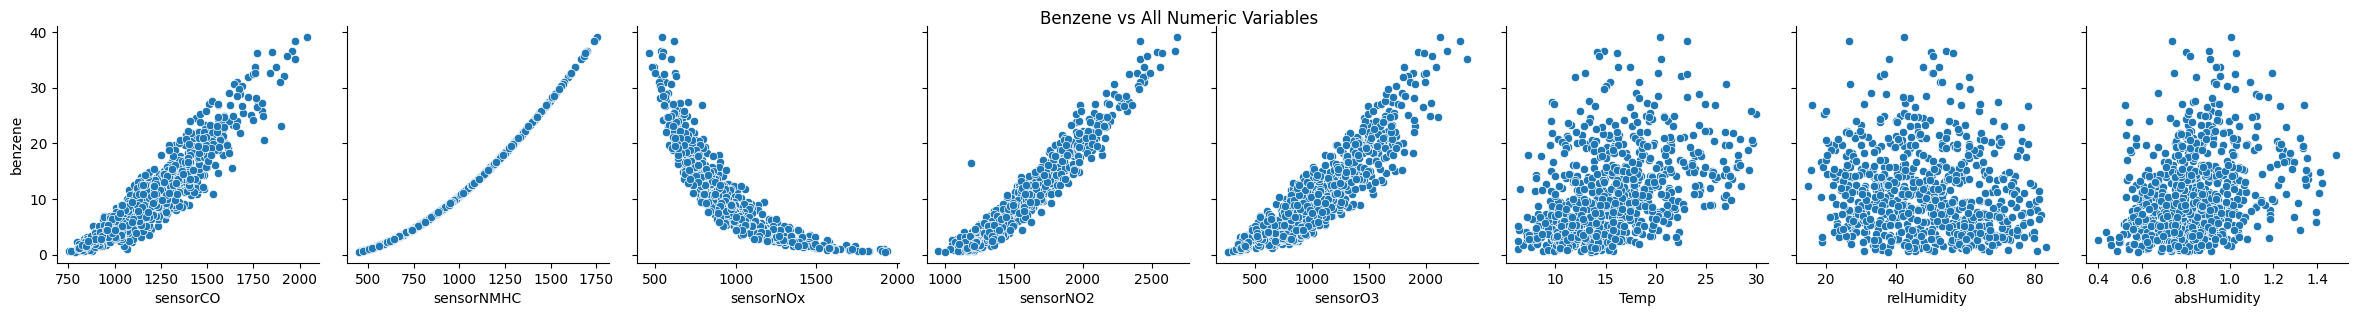

In [24]:
# list of variables
variables = ["benzene","sensorCO", "sensorNMHC", "sensorNOx",
             "sensorNO2", "sensorO3", "Temp",
             "relHumidity", "absHumidity"]

# list of numeric variables
numeric_vars = ["sensorCO", "sensorNMHC", "sensorNOx", "sensorNO2", "sensorO3", "Temp", "relHumidity", "absHumidity"]

# Use seaborn to create a pairplot of scatterplots with benzene as y-axis
sns.pairplot(
    sub_air[variables],
    x_vars=[v for v in variables if v != "benzene"],
    y_vars=["benzene"],
    height=3,
    aspect=1,
    kind="scatter"
)

plt.suptitle("Benzene vs All Numeric Variables", y=1.02)
plt.show()

With this pairwise collection of scatterplots, we can easily visualize the relationship between `benzene` and each numeric variable. We can observe similar trends that our correlation investigation revealed, such as the strong positive linear relationship between `benzene` and `sensorCO`, `sensorNMHC`, `sensorNO2`, and `sensorO3`. As well, as the strong negative linear relationship between `benzene` and `sensorNOx`, and the lack of relationship between `benzene` and our weather variables.

The next plot we may want to look at is a collection of boxplots for each categorical level variable and `benzene`.

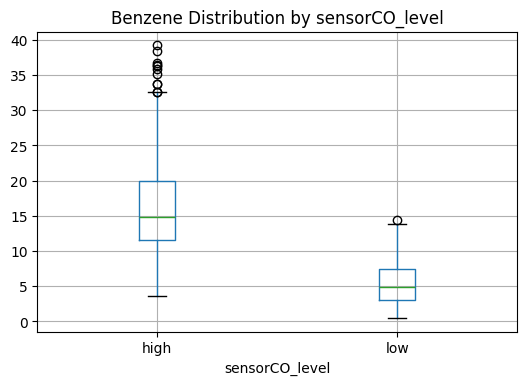

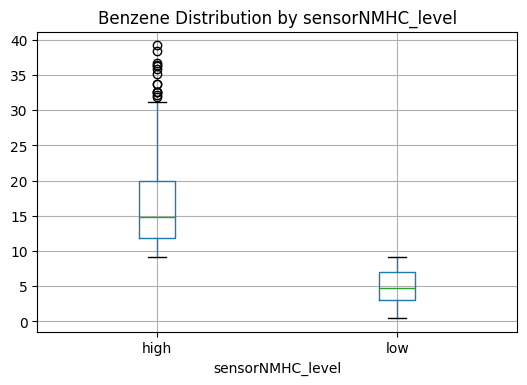

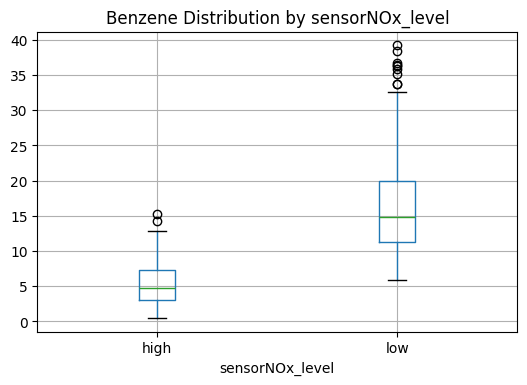

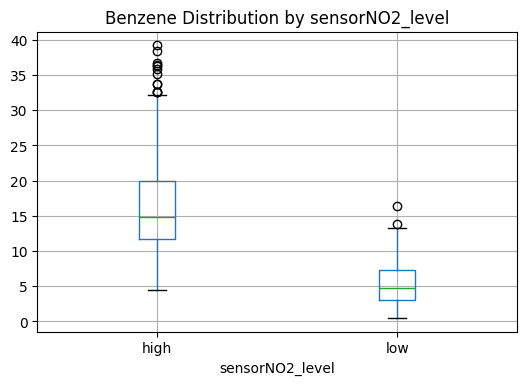

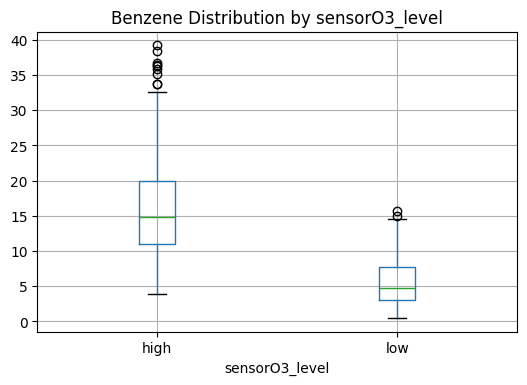

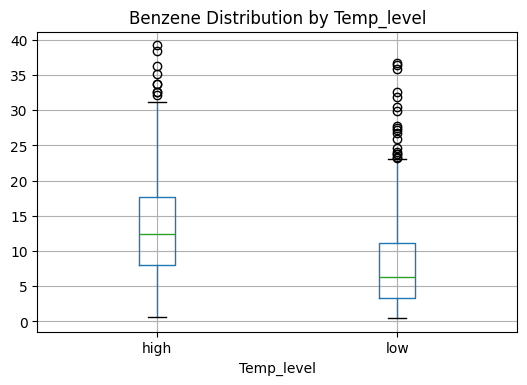

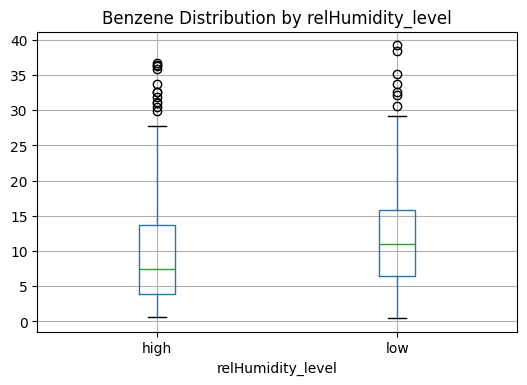

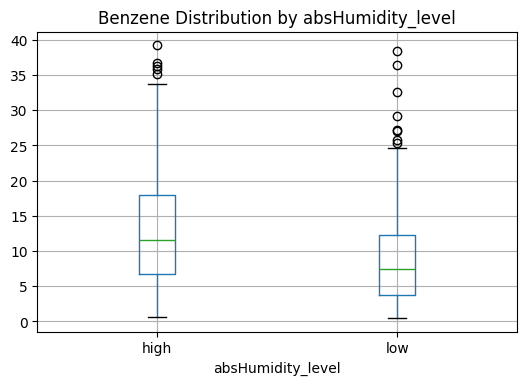

In [25]:
# create a boxplot for benzene, where the boxplot is split by the level of each categorical variable
for var in numeric_vars:
    level_var = f"{var}_level"
    ax = sub_air.boxplot(column="benzene", by=level_var, figsize=(6,4))
    plt.title(f"Benzene Distribution by {level_var}")
    plt.suptitle("")
    plt.show()

From these boxplots, we can observe a few trends among the relationship between the distribution of `benzene` and the different levels of each sensor. The first thing we note is that `sensorCO`, `sensorNMHC`, `sensorNO2`, and `sensorO3` all have similar distributions of `benzene` across the high and low levels, specifically where the `high` level has a greater spread of distribution with more outliers and a larger max value. We also see that the `sensorNOx` boxplot has an opposite effect, where the `low` level has a greater spread of distribution with more outliers and a larger max value, this lines up with negative linear relationship we saw in the correlations and scatterplot.

For the weather related boxplots, we note that for `Temp` the `low` level has a lot more outliers and has a smaller spread. The `absHumidity` boxplot has a similar observation; however, the `relHumidity` boxplot shows that the `high` and `low` levels have a similar distribution.

Next we may want to look at some kernel density plots for `benzene` across the categorical level variables.

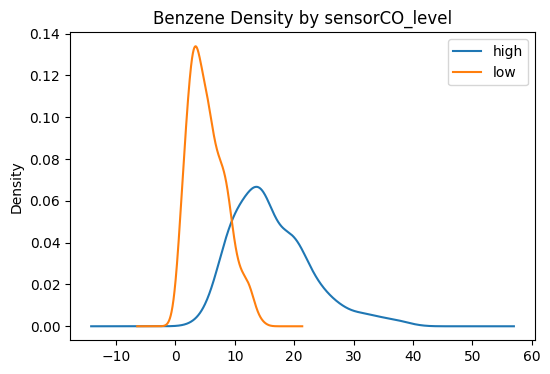

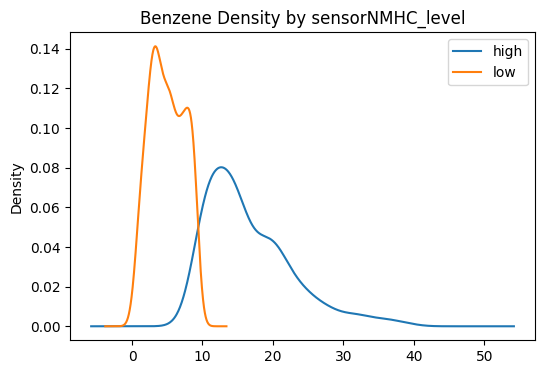

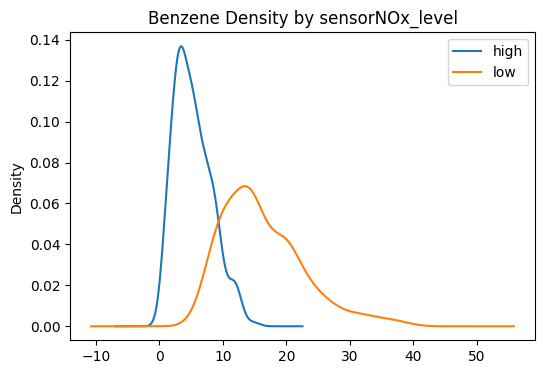

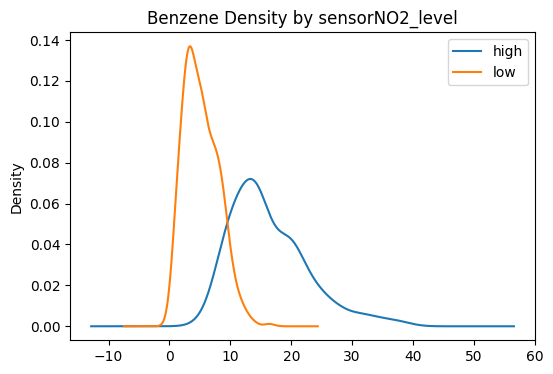

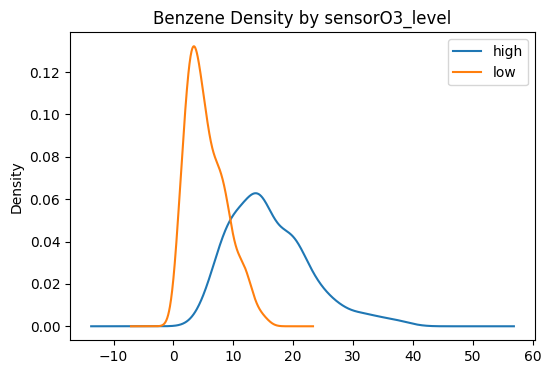

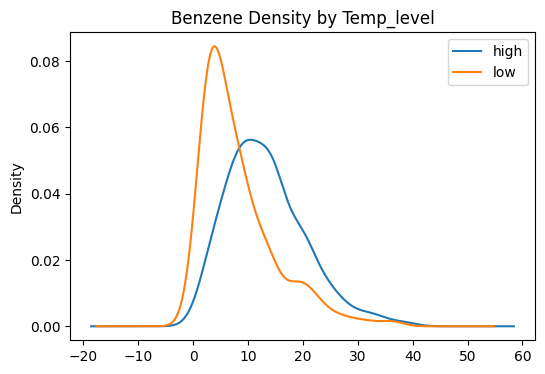

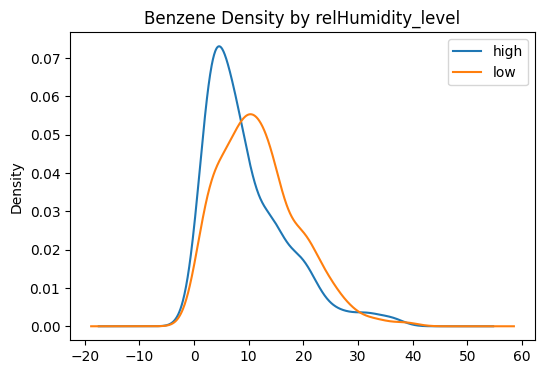

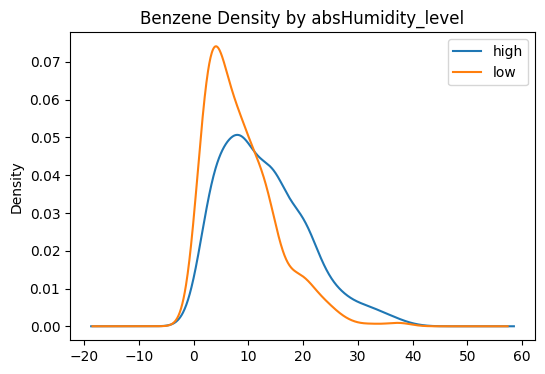

In [26]:
# Create kernel density plots for each numeric variable with benzene as the y-axis, color by level
for var in numeric_vars:
    level_var = f"{var}_level"
    grouped = sub_air.groupby(level_var, observed = True)["benzene"] #group by the levels

    fig, ax = plt.subplots(figsize=(6,4))
    for name, group in grouped:
        group.plot(kind="kde", label=name)

    plt.title(f"Benzene Density by {level_var}")
    plt.legend()
    plt.show()

These kernel density plots give us more of the same information, just in a different visual format. Specifically, we see that for the sensor variables (excluding `sensorNOx`), `Temp`, and `absHumidity` we see that the `low` level has a more compact distribution, whereas the `high` level is more spread out. And similar to the boxplots and scatterplots, the kernel density plots of `sensorNOx` and `relHumidity` show that the `high` level has a more compact distribution, whereas the `low` level is more spread out.

Now we may want to consider an interaction bar graph between the levels of temperature and relative humidity on the median of benzene. This would allow us to visualize the the two-level numeric summary we calculated earilier in the report. Here we see that the low and low level group has the lowest median benzene level, whereas the high and high level group has the highest median benzene level.

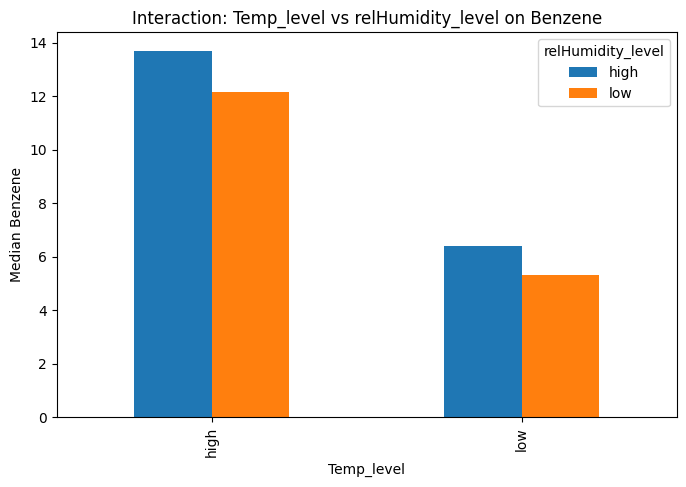

In [27]:
interaction = sub_air.groupby(["Temp_level", "relHumidity_level"], observed = True)["benzene"].median().unstack()

interaction.plot(kind="bar", figsize=(8,5))
plt.title("Interaction: Temp_level vs relHumidity_level on Benzene")
plt.ylabel("Median Benzene")
plt.show()

### Time Series Visualizations

This portion of our data visualizations will focus on the time series element of the data, i.e. the relationships between `benzene` and our created time and date variables.

The first plot we can create is a scatter plot that represents a by month breakdown of the median benzene level. From the plot, we see that March has the lowest median benzene level at a value of 9, whereas May has the highest median benzene level at a value of 15.


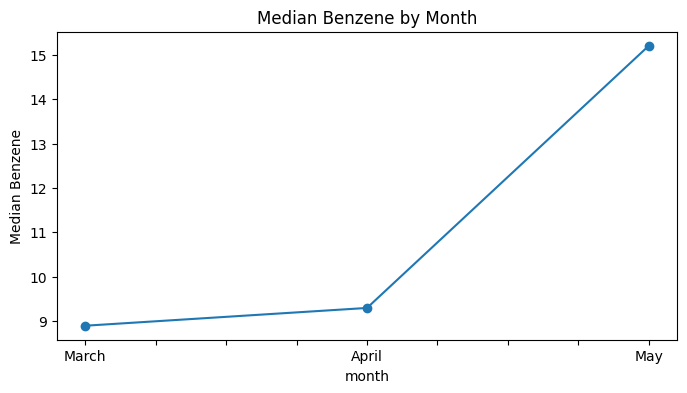

In [28]:
# benzene mean by month
sub_air.groupby("month", observed = True)["benzene"].median().plot(kind="line", marker="o", figsize=(8,4))
plt.title("Median Benzene by Month")
plt.ylabel("Median Benzene")
plt.show()

For the next time visualization, we may want to look a bar plot of the median benzene level for each day of the week. From the plot, we can observe that Friday has the highest median `benzene` level at a value around 13. Wherea, Sunday has the lowest median benzene level at a value a little over 4.

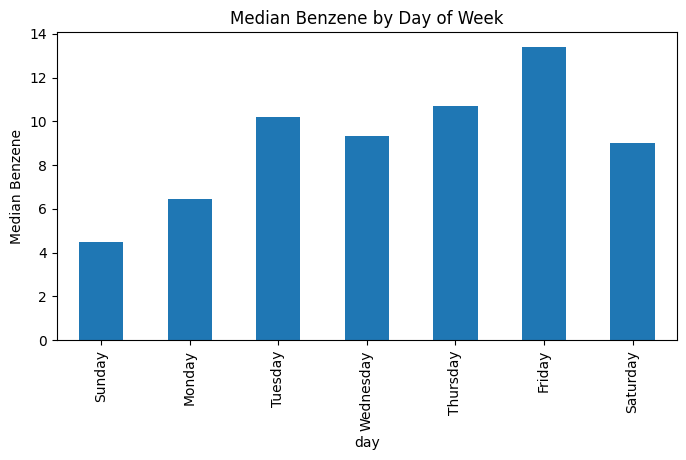

In [29]:
# benzene mean by day of week
sub_air.groupby("day", observed = True)["benzene"].median().plot(kind="bar", figsize=(8,4))
plt.title("Median Benzene by Day of Week")
plt.ylabel("Median Benzene")
plt.show()

Next, we create a bar plot of the median benzene level by `season` and see that the Winter season has a higher median benzene level that is close to a value of 12. Whereas, Spring has a lower benzene level that is close to a value of 8.

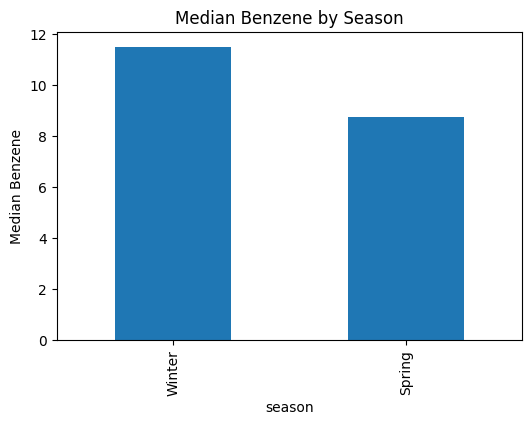

In [30]:
# benzene mean by season
sub_air.groupby("season", observed = True)["benzene"].median().plot(kind="bar", figsize=(6,4))
plt.title("Median Benzene by Season")
plt.ylabel("Median Benzene")
plt.show()

Next, we can look at a bar graph that examines the median benzene level by the `timeOfDay` variable. From the bar graph, we see that benzene levels are highest during the evening with a value around a value of 15, and lowest during dawn with a value around 3.

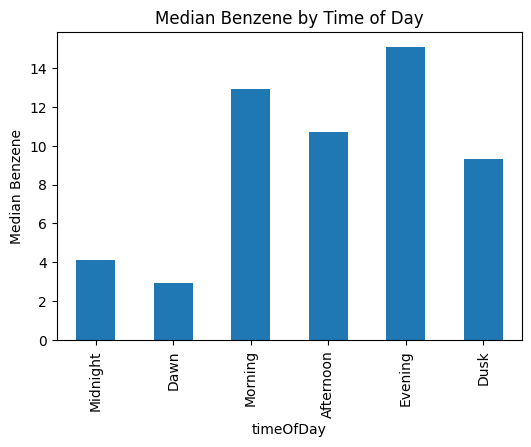

In [31]:
# benzene mean by time of day
sub_air.groupby("timeOfDay", observed = True)["benzene"].median().plot(kind="bar", figsize=(6,4))
plt.title("Median Benzene by Time of Day")
plt.ylabel("Median Benzene")
plt.show()

Next, we may want to look at the boxplots for `benzene` by each time variable.

For the `month` boxplots, we note that there are not many observations for the month of May, or there is a very narrow spread of observations. We see a little more spread among the month of April, with the 75th quartile and maximum being larger for April than March.

For the `day` boxplots, we see that Sunday has the smallest spread of data, followed by Saturday. We also see that although Friday has the highest median benzene level, Thursday has the largest spread with a higher max value. We also see a few outlier observations Sunday through Wednesday.

For the `year` boxplot, we note that there is only one year represented, and it appears to be quite skewed in distribution with quite a few outlier values.

We see that for the `season` boxplots, only Winter and Spring are captured in the data and they both have similar distributions.

Finally, for the `timeOfDay` boxplots, we see that Dawn has the tightest distribution and has a few outlier observations. We also see that although Evening has the larger median benzene level, the Morning time has a little more skewness to its distribtuion, with a higher maximum value.

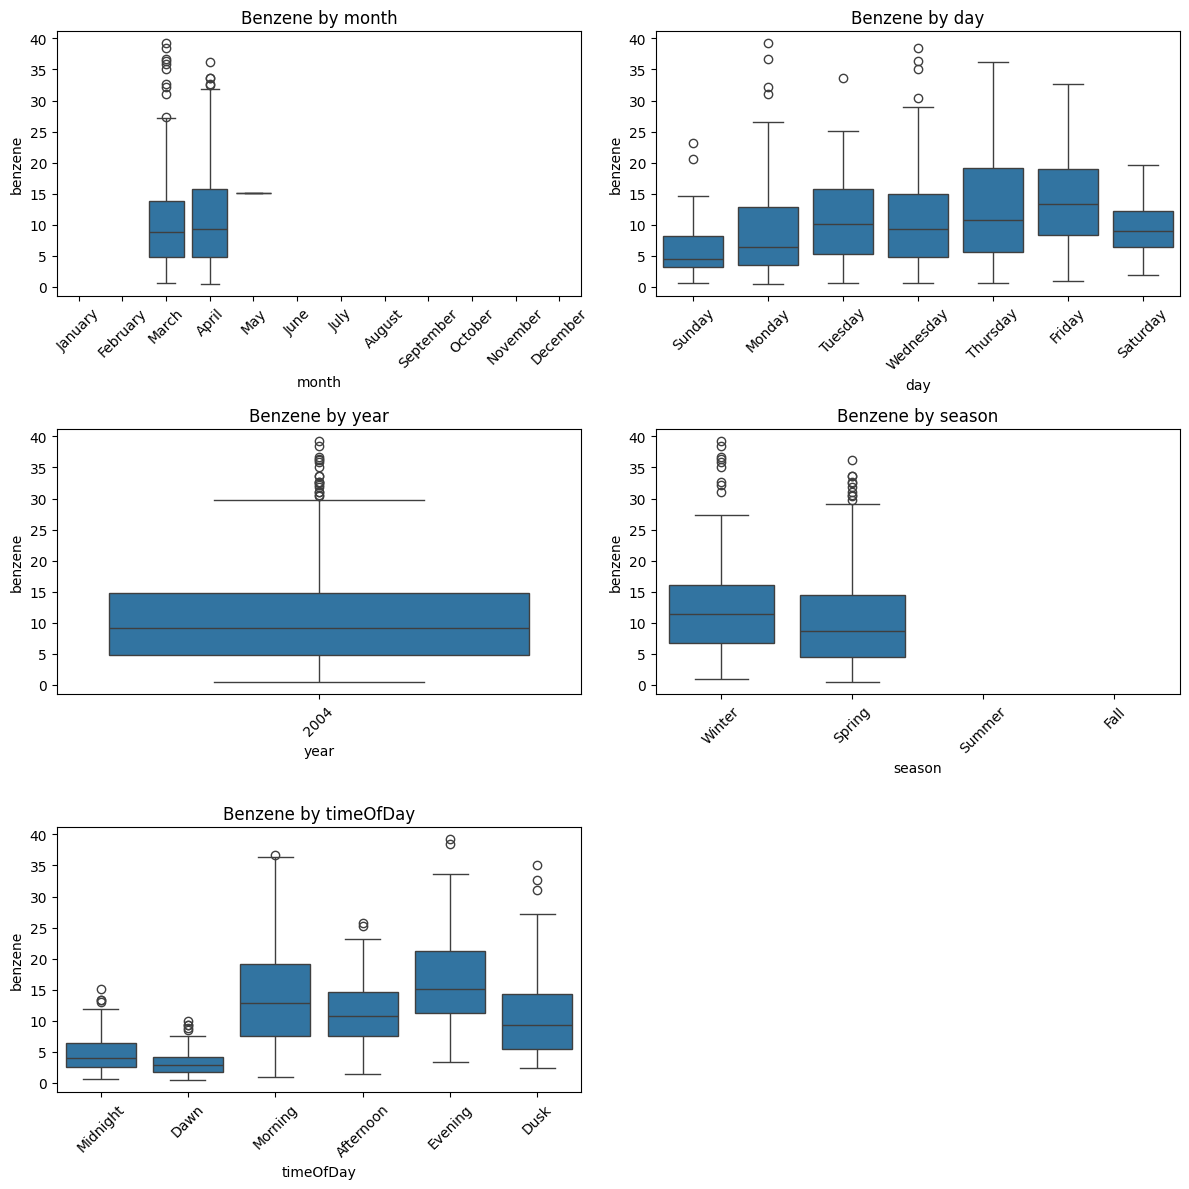

In [32]:
# create list of time variables
time_vars = ["month", "day", "year", "season", "timeOfDay"]

# set up subplot layout
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# create a boxplot with seaborn for each time variable
for i, var in enumerate(time_vars):
    sns.boxplot(data=sub_air, x=var, y="benzene", ax=axes[i])
    axes[i].set_title(f"Benzene by {var}")
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplot if needed
if len(time_vars) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Next, we want to look at our numeric variables and see how their median levels change across the three months of interest. We see a similar trend as the median benzene level, in the shape of a low to gradual high elbow, for most of the numeric variables, with a few exceptions. We see that `sensorNOx` has a higher median value in March and a lower median value in May. For `Temp` we see that April has a pretty high median value, although May remains the highest.

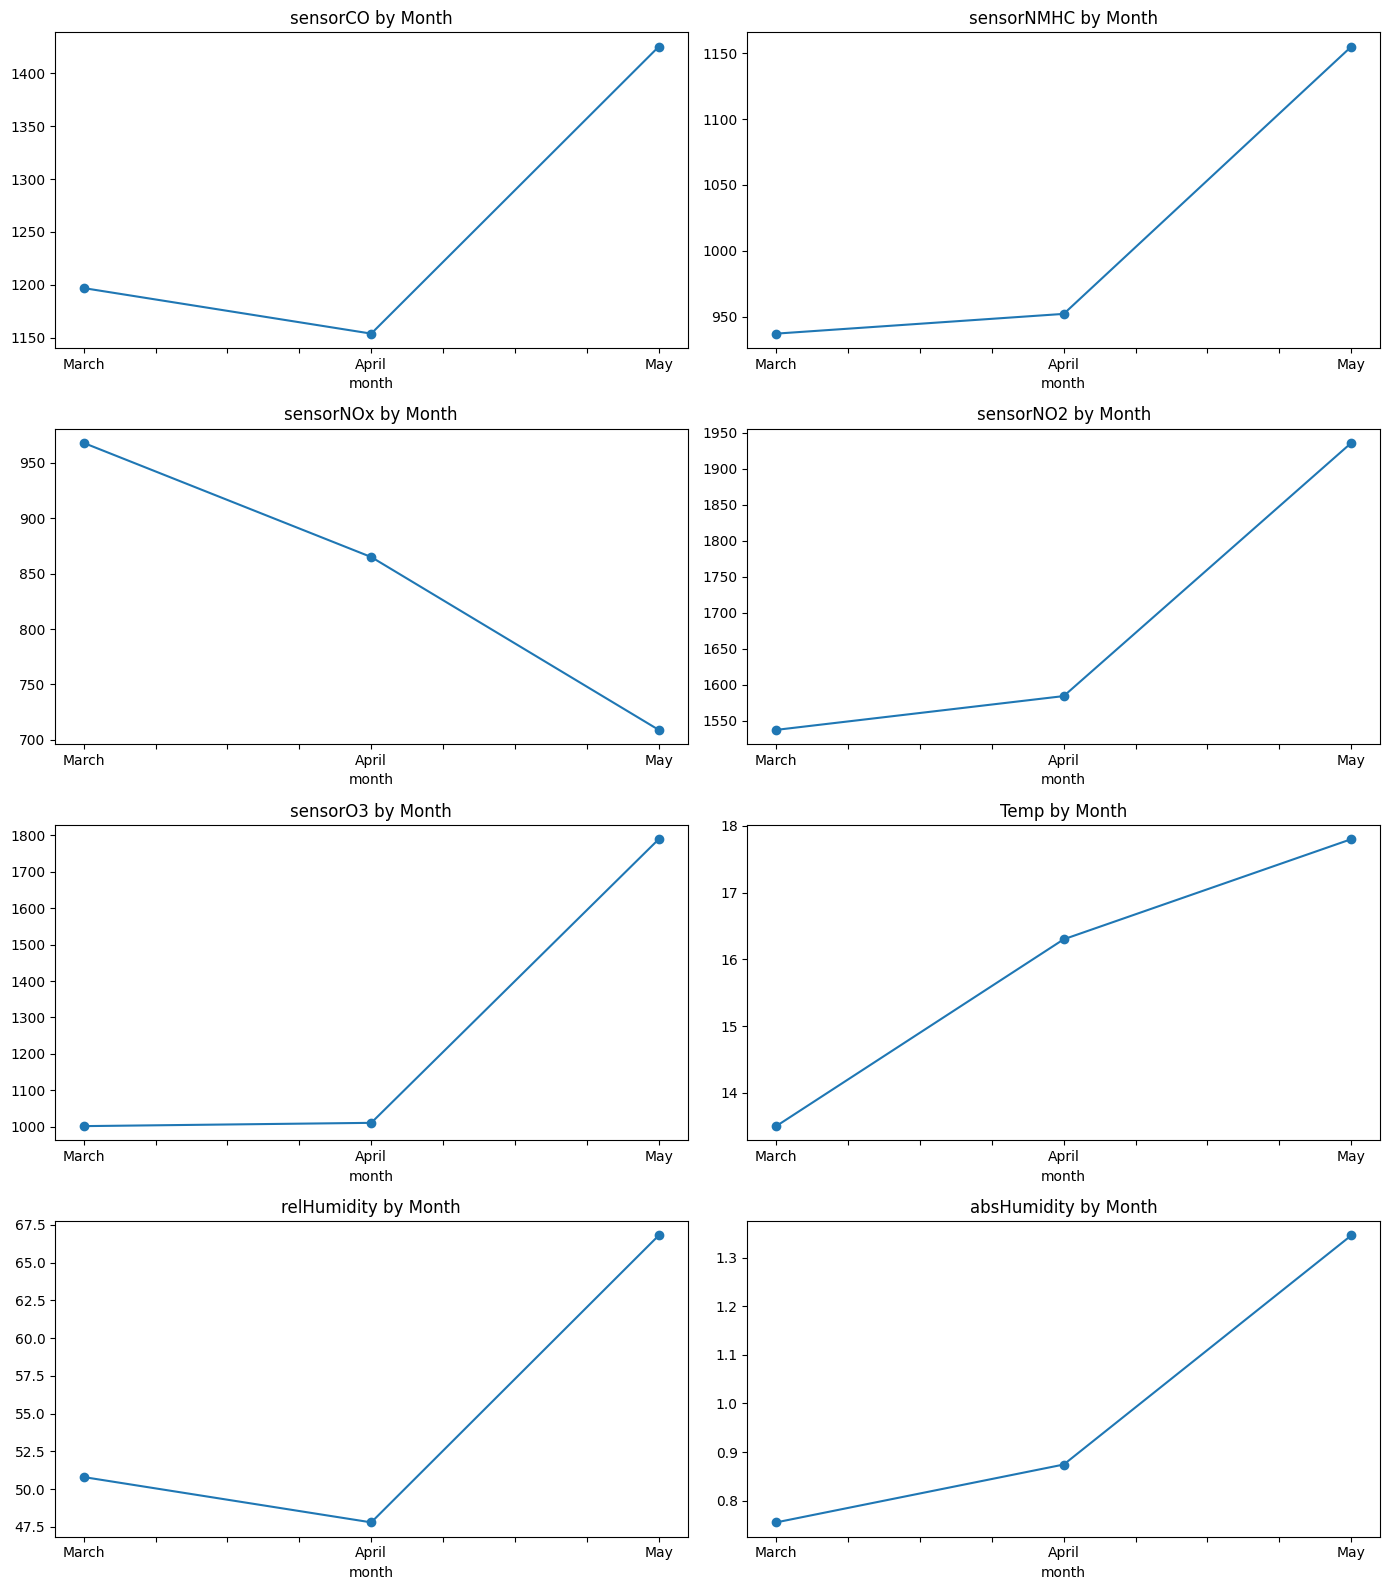

In [33]:
# create grid settings
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

# plot a line plot of the median of numeric variables by month
for i, var in enumerate(numeric_vars):
    sub_air.groupby("month", observed = True)[var].median().plot(ax=axes[i], marker="o")
    axes[i].set_title(f"{var} by Month")

plt.tight_layout()
plt.show()

Next we may want to look at a heatmap that investigates the median benzene level by both `month` and `timeOfDay`. The heatmap uses a color variation to inform us on how high the median benzene level is, with a warmer tone representing a higher median and a cooler tone representing a lower median. From the heatmap we see that Evenings in April had the highest median benzene level and Dawn in March had the lowest median benzene level. We also see a trend across the time of day for each month, with lower levels of `benzene` being found during Midnight and Dawn, with the levels increasing in the Morning, Afternoon, and Evening, and dropping again at Dusk.

/tmp/ipython-input-2445819930.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub_air.pivot_table(


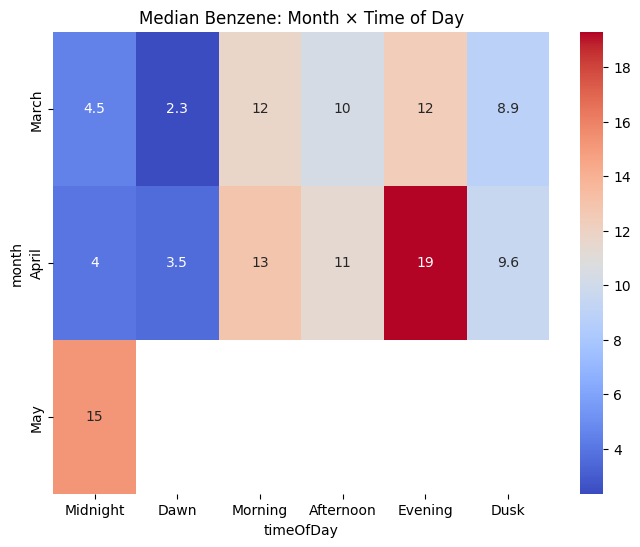

In [34]:
# get median values of benzene for month and time of day
pivot = sub_air.pivot_table(
    values="benzene",
    index="month",
    columns="timeOfDay",
    aggfunc="median"
)

# create heatmap
plt.figure(figsize=(8,6))
sns.heatmap(pivot, cmap="coolwarm", annot=True)
plt.title("Median Benzene: Month × Time of Day")
plt.show()

Next, we create a second heatmap, but this time we can investigate the relationship between the median benzene level across `day` and `season`. From this heatmap we see that Mondays in Winter have the highest median benzene level. Whereas, Sundays in Spring have the lowest median benzene level. We also note that the median values for `benzene` are much lower during the Spring, a trend we noted earlier.

/tmp/ipython-input-3780432053.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot2 = sub_air.pivot_table(


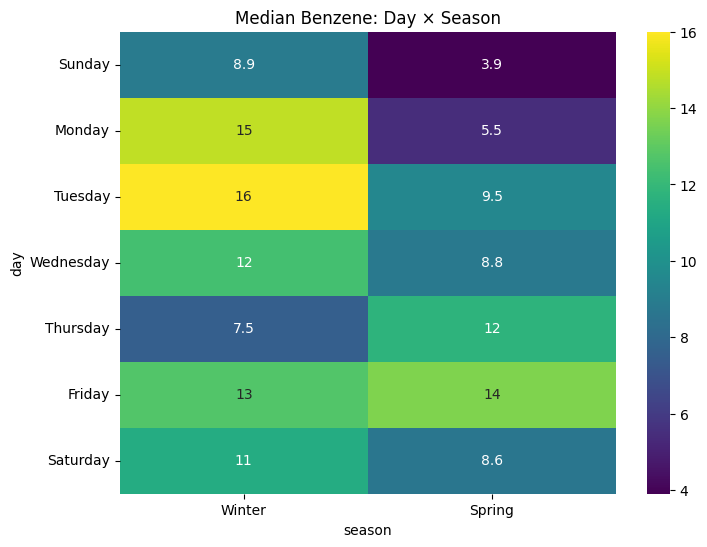

In [35]:
# get median values of bezene for day and season
pivot2 = sub_air.pivot_table(
    values="benzene",
    index="day",
    columns="season",
    aggfunc="median"
)

# create heatmap
plt.figure(figsize=(8,6))
sns.heatmap(pivot2, cmap="viridis", annot=True)
plt.title("Median Benzene: Day × Season")
plt.show()

Finally, we may want to look at `benzene` across the overall time points and examine the 30 day rolling average of benzene levels. A 30-day rolling average plot allows us to graph the average benzene level based on the previous 30 days and to get daily updates. These daily updates allow us to move forward in time by adding in newly collected data and dropping any data older than 30 days. From this rolling average plot, we see that there are a lot of fluctuations in benzene levels across the collected time points. This corresposnds to the observations we've made earlier with our various time variables.

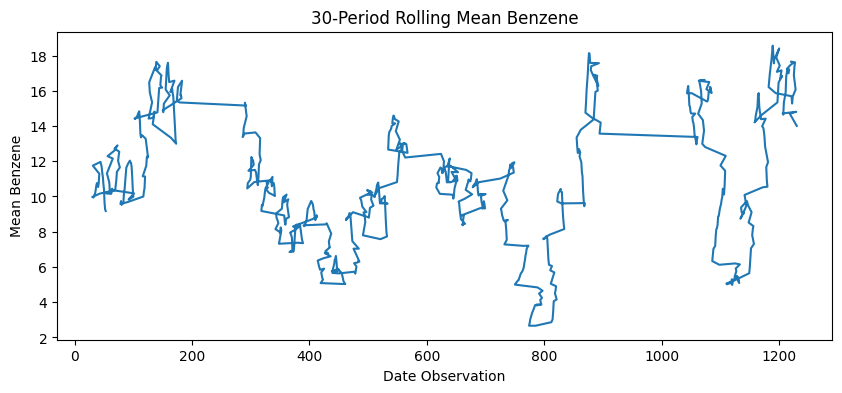

In [36]:
# rolling monthly trend
sort_air = sub_air.sort_values("Date")  # if you have a datetime column

sort_air["benzene"].rolling(30).mean().plot(figsize=(10,4))
plt.title("30-Period Rolling Mean Benzene")
plt.ylabel("Mean Benzene")
plt.xlabel("Date Observation")
plt.show()

## Conclusion

Overall, there are so many unique observations that can be made using this `air` dataset. We've investigated the numerical summaries for `benzene` and the sensor variables, `Temp` and `relHumidity`. We also looked at the correlations between the numeric variables, and even the correlations between the ground truth readings and the sensor readings. We then moved into our data visualization portion of our EDA and explored a lot of different relationships between the level version of our sensor variables and then the relationship of the median benzene level across our create time variables. There are so many more relationships that could be examined, so this report only serves as a good overview and starting point to this investigation into benzene levels.